Use pretrained fully connected layer using QBCM objective function and local gradient and fully connected output layer to perform digit classification.

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
import matplotlib.pyplot as plt
from local_lr import QBCM_tf
from local_lr import data_loader

% matplotlib inline

In [8]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('\tmp\data')

Extracting 	mp\data/train-images-idx3-ubyte.gz
Extracting 	mp\data/train-labels-idx1-ubyte.gz
Extracting 	mp\data/t10k-images-idx3-ubyte.gz
Extracting 	mp\data/t10k-labels-idx1-ubyte.gz


In [9]:
# Preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_std=False)

X_train = mnist.train.images
X_train = X_train[:1000,:]
X_test = mnist.test.images
X_train_demean = scaler.fit_transform(X_train)
X_test_demean = scaler.transform(X_test)
graph = tf.Graph()
with graph.as_default():
    sess = tf.Session()
    y_train = sess.run(tf.cast(mnist.train.labels, tf.int32))

In [26]:
# Give the training parameter
tf.reset_default_graph()

learning_rate = 0.0001
epochs = 1000

# Build the network
n_input = 784
n_output = 100

X = tf.placeholder(tf.float32, shape=(None, n_input), name='X')

# Initializet he variable
initializer = tf.contrib.layers.variance_scaling_initializer()

w_init = initializer([n_input, n_output])

w = tf.Variable(w_init, tf.float32, name='weights')

output = tf.matmul(tf.transpose(X), w)

# Define the loss function
loss = QBCM_tf.QBCM_obj(X, w)

# Choose the training algorithm
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
trainer = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [4]:
# Use tensorflow to train one layer fully connected network with objective function 
# of QBCM, relu activation and l2 regularizaiton

# Define the training operation
with tf.Session() as sess:
    init.run()
    
    weights_track = []
    for i in range(epochs):    # Objective function training needs to use all the available data
        trainer.run(feed_dict={X:X_train_demean})
        weights = w.eval()
        weights_track.append(weights)
        save_path = saver.save(sess, "/tmp/BCM_obj_lr0.0001_epoch1000.ckpt")

In [27]:
# Visualze the weights
with tf.Session() as sess:
    saver.restore(sess, "/tmp/BCM_obj_lr0.0001_epoch1000.ckpt")
    weight = w.eval()

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


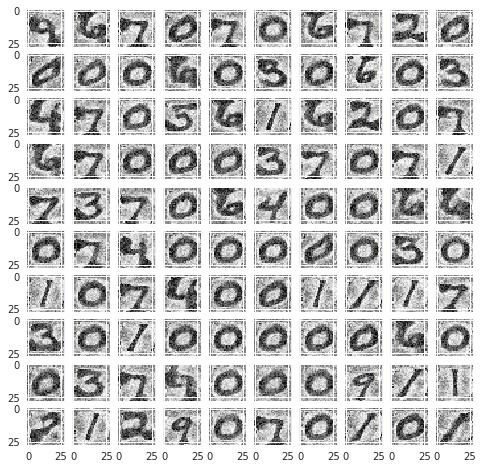

In [28]:
n_row = 10
n_col = 10
fig, axes = plt.subplots(n_row, n_col, sharex=True, sharey=True)
fig.set_figwidth(8)
fig.set_figheight(8)

for i in range(n_row):
    for j in range(n_col):
        axes[i][j].imshow(weight[:, i * n_col + j].reshape(28,28), cmap="Greys")

In [52]:
# Freeze the lower layer and train only the upper layer
n_input = 784
n_hidden = 100
n_ouput = 784
learning_rate = 0.0001
l2_reg=0.1
epochs = 1000
batch_size=256

# build the initializer and regularizer
initializer = tf.contrib.layers.variance_scaling_initializer()
regularizar = tf.contrib.layers.l2_regularizer(l2_reg)

X = tf.placeholder(dtype=tf.float32, shape=[None, n_input],  name='X')

w1 = tf.constant(weight)
w2 = tf.Variable(initializer([n_hidden, n_input]), dtype=tf.float32, name='w2' )
# w2 = tf.get_variable('w2', shape=[n_hidden, n_output], initializer=initializer)

hidden = tf.nn.relu(tf.matmul(X, w1))
output = tf.matmul(hidden, w2)

recon_loss = tf.reduce_sum(tf.square(output - X))
loss = recon_loss

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_var = [w2]
train_op = optimizer.minimize(recon_loss, var_list=train_var)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()

    for i in range(epochs):
        for j in range(X_train_demean.shape[0]//batch_size):
            xi = X_train_demean[j*batch_size:(j+1)*batch_size, :]
            train_op.run(feed_dict={X:xi})
        if i % 100 == 0:
            save_path = saver.save(sess, "/tmp/MNIST_recon_pretrain_BCM_obj_lr0.0001_epoch1000.ckpt")
            print('Epoch{a}, loss={b}'.format(a=i,b=loss.eval(feed_dict={X:xi})))
    output.eval(feed_dict={X:X_train_demean[0,:].reshape(-1, 784)})
    save_path = saver.save(sess, "/tmp/MNIST_recon_pretrain_BCM_obj_lr0.0001_epoch1000.ckpt")

Epoch0, loss=1225149.0
Epoch100, loss=5720.1328125
Epoch200, loss=4717.04296875
Epoch300, loss=4592.3603515625
Epoch400, loss=4559.7265625
Epoch500, loss=4548.85888671875
Epoch600, loss=4544.7568359375
Epoch700, loss=4543.08935546875
Epoch800, loss=4542.35546875
Epoch900, loss=4542.0263671875


In [49]:
test_idx = 100
with tf.Session() as sess:
    saver.restore(sess, "/tmp/MNIST_recon_pretrain_BCM_obj_lr0.0001_epoch1000.ckpt")
    output_test = output.eval(feed_dict={X:X_train_demean[test_idx,:].reshape(-1, 784)})

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


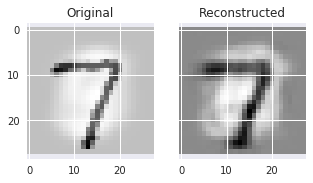

In [50]:
# Compare original and reconstructed inmages
fig, axes = plt.subplots(1,2,sharex=True, sharey=True)
fig.set_figwidth(5)
fig.set_figheight(2.5)
axes[0].imshow(X_train_demean[test_idx,:].reshape(28,28),cmap='Greys')
axes[0].set_title('Original')
axes[1].imshow(output_test.reshape(28, 28),cmap='Greys')
axes[1].set_title('Reconstructed')

In [ ]:
# np.save('QBCM_obj_55000_stochastic_epcoh1000', weights)

In [62]:
data = X_train_demean
dim_x = data.shape[1]
n_output = 100
eta_set = 0.0001
decay = 2
p = 2
tau = 200
epoch=25
sample_size = data.shape[0]

tf.reset_default_graph()
# Give input place holder
input_value = tf.placeholder(tf.float32, [1, dim_x])
obj_input = tf.placeholder(tf.float32, [sample_size, dim_x])
eta = tf.placeholder(tf.float32)

# Varaible
w = tf.Variable(tf.random_normal([dim_x, n_output]))
threshold = tf.Variable(tf.zeros([1, n_output]))

### Computation steps
# Compute output with ReLU
net_input = tf.matmul(input_value, w)
output_value = tf.nn.relu(net_input)

# Update weights with QBCM learning rule
out_thre_diff = output_value - threshold
delta_w = eta * tf.matmul(input_value, tf.multiply(output_value, out_thre_diff), transpose_a = True)- eta * decay * w
new_w = w + delta_w
update_w = tf.assign(w, new_w)

# Update threshold
h = tf.exp(-1/tau)
new_thres = threshold * h + tf.pow(output_value, p) * (1 - h)
update_thres = tf.assign(threshold, new_thres)

# Calculate QBCM objective function
obj_net_input = tf.matmul(obj_input, w)
obj_output = tf.nn.relu(obj_net_input)
obj1 = tf.reduce_mean(tf.pow(obj_output, 3))
obj2 = tf.reduce_mean(tf.pow(obj_output, 2))
obj = obj1/3 - tf.pow(obj2, 2)/4

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [59]:
with tf.Session() as sess:
    init.run()

    for i in range(epoch):
        tf.random_shuffle(data)
        #eta_set = eta_set/3
        for j in range(data.shape[0]):
            sess.run(update_w, feed_dict = {input_value: data[j,:].reshape(1,data.shape[1]), eta:eta_set})
            sess.run(update_thres, feed_dict = {input_value: data[j,:].reshape(1,data.shape[1]), eta:eta_set})
            # w_track.append(sess.run(w))
            # thres_track.append(sess.run(threshold))
        print('Epoch{a}: obj={b}'.format(a=i, b=sess.run(obj, feed_dict = {obj_input: data, eta:eta_set})))
        save_path = saver.save(sess, "/tmp/BCM_gradient_lr0.0001_epoch100.ckpt")

Epoch0: obj=6.900834083557129
Epoch1: obj=13.863160133361816
Epoch2: obj=18.131479263305664
Epoch3: obj=20.221464157104492
Epoch4: obj=21.257503509521484
Epoch5: obj=21.849590301513672
Epoch6: obj=22.24428939819336
Epoch7: obj=22.54792022705078
Epoch8: obj=22.78740119934082
Epoch9: obj=22.961307525634766
Epoch10: obj=23.063024520874023
Epoch11: obj=23.11227798461914
Epoch12: obj=23.135324478149414
Epoch13: obj=23.146442413330078
Epoch14: obj=23.152042388916016
Epoch15: obj=23.154918670654297
Epoch16: obj=23.156421661376953
Epoch17: obj=23.157249450683594
Epoch18: obj=23.157695770263672
Epoch19: obj=23.157974243164062
Epoch20: obj=23.15813446044922
Epoch21: obj=23.15822982788086
Epoch22: obj=23.15829849243164
Epoch23: obj=23.158327102661133
Epoch24: obj=23.158349990844727


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


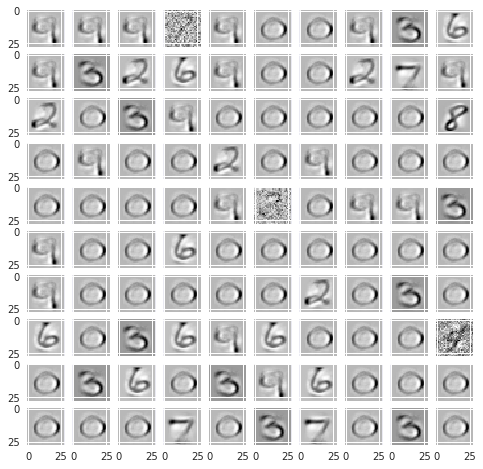

In [70]:
n_row = 10
n_col = 10
fig, axes = plt.subplots(n_row, n_col, sharex=True, sharey=True)
fig.set_figwidth(8)
fig.set_figheight(8)

for i in range(n_row):
    for j in range(n_col):
        axes[i][j].imshow(w[:, i * n_col + j].reshape(28,28), cmap="Greys")

In [72]:
# Freeze the lower layer and train only the upper layer
n_input = 784
n_hidden = 100
n_ouput = 784
learning_rate = 0.0001
l2_reg=0.1
epochs = 1000
batch_size=256

# build the initializer and regularizer
initializer = tf.contrib.layers.variance_scaling_initializer()
regularizar = tf.contrib.layers.l2_regularizer(l2_reg)

X = tf.placeholder(dtype=tf.float32, shape=[None, n_input],  name='X')

w1 = tf.constant(w)
w2 = tf.Variable(initializer([n_hidden, n_input]), dtype=tf.float32, name='w2' )
# w2 = tf.get_variable('w2', shape=[n_hidden, n_output], initializer=initializer)

hidden = tf.nn.relu(tf.matmul(X, w1))
output = tf.matmul(hidden, w2)

recon_loss = tf.reduce_sum(tf.square(output - X))
loss = recon_loss

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_var = [w2]
train_op = optimizer.minimize(recon_loss, var_list=train_var)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()

    for i in range(epochs):
        for j in range(X_train_demean.shape[0]//batch_size):
            xi = X_train_demean[j*batch_size:(j+1)*batch_size, :]
            train_op.run(feed_dict={X:xi})
        if i % 100 == 0:
            save_path = saver.save(sess, "/tmp/MNIST_recon_pretrain_BCM_grad_lr0.0001_epoch1000.ckpt")
            print('Epoch{a}, loss={b}'.format(a=i,b=loss.eval(feed_dict={X:xi})))
    output.eval(feed_dict={X:X_train_demean[0,:].reshape(-1, 784)})
    save_path = saver.save(sess, "/tmp/MNIST_recon_pretrain_BCM_grad_lr0.0001_epoch1000.ckpt")

Epoch0, loss=1973945.0
Epoch100, loss=11578.6259765625
Epoch200, loss=11482.4775390625
Epoch300, loss=11486.5322265625
Epoch400, loss=11486.810546875
Epoch500, loss=11486.736328125
Epoch600, loss=11486.7578125
Epoch700, loss=11486.7431640625
Epoch800, loss=11486.76953125
Epoch900, loss=11486.7421875


In [73]:
test_idx = 100
with tf.Session() as sess:
    saver.restore(sess, "/tmp/MNIST_recon_pretrain_BCM_grad_lr0.0001_epoch1000.ckpt")
    output_test = output.eval(feed_dict={X:X_train_demean[test_idx,:].reshape(-1, 784)})

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


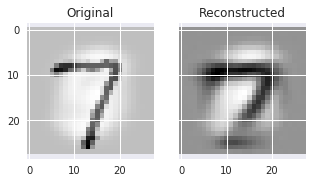

In [74]:
# Compare original and reconstructed inmages
fig, axes = plt.subplots(1,2,sharex=True, sharey=True)
fig.set_figwidth(5)
fig.set_figheight(2.5)
axes[0].imshow(X_train_demean[test_idx,:].reshape(28,28),cmap='Greys')
axes[0].set_title('Original')
axes[1].imshow(output_test.reshape(28, 28),cmap='Greys')
axes[1].set_title('Reconstructed')